# Imports, Setup, Dataset

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import yfinance as yf
from numpy import linalg as LA
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import coint
from itertools import combinations
import matplotlib.dates as mdates
from datetime import datetime
import random
import matplotlib.gridspec as gridspec
import matplotlib

In [2]:
cap_path = '/Users/tuckeringlefield/Desktop/Data_Science/Math_4920/Stocks_Data/cap_data_from_shardar.csv'
price_path = "/Users/tuckeringlefield/Desktop/Data_Science/Math_4920/Stocks_Data/price_data_from_shardar.csv"

# Reading Data:
prices_df = pd.read_csv(price_path, index_col='date')
caps_df = pd.read_csv(cap_path, index_col='date')

# Drop troubled stock...
prices_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)
caps_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)

prices_df.head()
caps_df.head()

,ATW,A,AA,AAAB,AABC,AAC1,AACC,AACE,AACH,AADI,...,ZVIA,ZVOI,ZVRA,ZVUE,ZVXI,ZY,ZYME,ZYNE,ZYXI,ZZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.265785,14.803789,NaN,0.002968,0.000000,0.055383,NaN,0.074688,NaN,NaN,...,NaN,NaN,NaN,NaN,0.010821,NaN,NaN,NaN,NaN,NaN
2000-01-04,0.355094,13.938379,NaN,0.001050,0.000000,0.093997,NaN,0.036322,NaN,NaN,...,NaN,NaN,NaN,NaN,0.001050,NaN,NaN,NaN,NaN,NaN
2000-01-05,0.597657,15.593232,NaN,0.002262,0.000000,0.082724,NaN,0.042248,NaN,NaN,...,NaN,NaN,NaN,NaN,0.002725,NaN,NaN,NaN,NaN,NaN
2000-01-06,0.377474,6.688876,NaN,0.003307,0.000000,0.071145,NaN,0.022496,NaN,NaN,...,NaN,NaN,NaN,NaN,0.006309,NaN,NaN,NaN,NaN,NaN
2000-01-07,0.698268,8.061751,NaN,0.001843,0.000426,0.061952,NaN,0.005193,NaN,NaN,...,NaN,NaN,NaN,NaN,0.033459,NaN,NaN,NaN,NaN,NaN


In [3]:
prices_df.index = pd.to_datetime(prices_df.index)

# Get the initial start and end date
start_date = prices_df.index[0]
end_date = prices_df.index[-1]

# Download additional data:
spy_data = yf.download('SPY', start=start_date, end=end_date, interval='1d')
spy_data = pd.DataFrame(spy_data["Adj Close"])
spy_data.rename({"Adj Close": 'SPY'}, inplace=True, axis=1)

# Set up dataframes:
prices_with_market = prices_df.merge(spy_data, how='left', left_index=True, right_index=True)

[*********************100%%**********************]  1 of 1 completed


In [4]:
# Pulling rougly the first half of data
num_rows = len(prices_df)
print(f'Original Length: {num_rows}')
train_df = prices_df[:np.round(num_rows/2).astype(int)]
num_rows = len(train_df)
print(f'Train Length: {num_rows}')

Original Length: 5787
Train Length: 2894


In [5]:
# Let's identify stocks with no null values
complete_stock_list = train_df.columns
non_null_stocks = []
for stock in complete_stock_list:
    # get the count of nulls
    null_count = train_df[stock].isnull().sum()
    if null_count == 0:
        non_null_stocks.append(stock)

print(len(complete_stock_list))
print(len(non_null_stocks))

10806
2467


# Sectors

In [6]:
# non_null_stocks is the list of usable stocks
query = "EQR"

matches = [s for s in non_null_stocks if query in s]
print(matches)

['EQR']


In [7]:
Market_dict = {
    'Technology': ['AAPL','MSFT','NVDA','ORCL','CSCO','IBM','ADBE','AMD','TXN','INTC'],
    'Financial Services' : ['AXP','BLK','PGR','','','','','','',''],
    'Consumer Cyclical': ['AMZN','HD','MCD','BKNG','LOW','TJX','SBUX','ORLY','',''],
    'Healthcare' : ['LLY','UNH','JNJ','MRK','ABT','AMGN','CVS','','',''],
    'Communication Services': ['TTWO','OMC','EA','','','','','','',''],
    'Industrials' : ['CAT','UNP','HON','BA','DE','ETN','UPS','WM','MMM','CTAS'],
    'Consumer Defensive' : ['WMT','COST','PG','KO','PEP','MO','CL','TGT','MNST','KR'],
    'Energy': ['XOM','COP','CVX','EPD','EOG','WMB','SLB','OKE','VLO','EQT'],
    'Basic Materials' : ['SHW','APD','SCCO','ECL','NEM','VMC','MLM','NUE','PPG','STLD'],
    'Real Estate' : ['PLD','AVB','CSGP','IRM','EQR','','','','',''],
    'Utilities': ['','','','','','','','','','']
}
# This is just some of the stocks that are available... maybe this could be better solved later

# Functions

In [8]:
def get_corr_matrix(DataFrame):
    return DataFrame.corr()

In [9]:
def cluster(DataFrame, num_clusters):
    X = get_corr_matrix(DataFrame)
    kmeans = KMeans(n_clusters=num_clusters, random_state=2, n_init=20).fit(X)
    cluster_dict = {}
    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = DataFrame.columns[i]
        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]
    return cluster_dict

In [10]:
def monthly_clustering(DataFrame, months_to_run):
    # Set up the log
    cluster_log = {}
    # Get the list of timestamps (assuming the index is a list of Timestamps)
    index = DataFrame.index.tolist()
    # Start from the first timestamp
    first_day = index[0]
    for _ in range(months_to_run):
        # Calculate the last day of the month based on the current first day
        last_day_of_month = pd.Timestamp(first_day.year, first_day.month, 1) + pd.offsets.MonthEnd(0) 
        # Cluster data for the month
        cluster_entry = cluster(DataFrame[first_day:last_day_of_month], 2)
        cluster_log[last_day_of_month] = cluster_entry 
        # Find the index position of the last day of the month in the list of timestamps
        last_day_position = None
        current_last_day = last_day_of_month 
        # Keep searching until we find a valid index position for the last day of the month
        while last_day_position is None:
            try:
                last_day_position = next(
                    i for i, t in enumerate(index) if t.date() == current_last_day.date()
                )
            except StopIteration:
                # Backtrack by one day and try again if not found
                current_last_day -= pd.Timedelta(days=1)
                # If backtracking goes too far, raise an error
                if current_last_day < first_day:
                    raise ValueError(
                        f"Could not find a suitable last day for the month starting at {first_day}. "
                        "Backtracking exceeded the first day."
                    )
        # Move to the next day after the last day of this month
        next_day = current_last_day + pd.Timedelta(days=1)
        # Keep moving to the next day until a valid first day is found
        while next_day not in index:
            next_day += pd.Timedelta(days=1)
        # Set the first day for the next month
        first_day = next_day
    return cluster_log

In [11]:
def weekly_clustering(DataFrame, weeks_to_run):
    # Set up the log
    cluster_log = {}
    # Get the list of timestamps (assuming the index is a list of Timestamps)
    index = DataFrame.index.tolist()
    # Start from the first timestamp
    first_day = index[0]
    index_position = 0  # Keeps track of the current position in the list of timestamps
    for _ in range(weeks_to_run):
        # Calculate the last day of the week based on the current first day
        last_day_of_week = first_day + pd.Timedelta(days=(6 - first_day.weekday()))  # Last day of the week (Sunday)
        # Ensure last_day_of_week is within the available data range
        if last_day_of_week > index[-1]:
            last_day_of_week = index[-1]
        # Cluster data for this week
        cluster_entry = cluster(DataFrame[first_day:last_day_of_week], 2)
        cluster_log[last_day_of_week] = cluster_entry
        # Move to the next day after the last day of this week
        next_day = last_day_of_week + pd.Timedelta(days=1)
        # Keep moving to the next day until a valid index is found
        while next_day not in index:
            next_day += pd.Timedelta(days=1)
        # Set the first day of the next week
        first_day = next_day
    return cluster_log

In [12]:
def convert_log_to_df(cluster_dict):
    # Create a list to hold DataFrame rows
    rows = []
    # Populate the rows with timestamp, stock, and cluster
    for timestamp, clusters in cluster_dict.items():
        for cluster_id, stocks in clusters.items():
            for stock in stocks:
                rows.append({'timestamp': timestamp, 'stock': stock, 'cluster': cluster_id})
    # Create the DataFrame
    df = pd.DataFrame(rows)
    # Pivot the DataFrame to get the desired format
    result = df.pivot(index='timestamp', columns='stock', values='cluster')
    return result

In [13]:
def cluster_viz(cluster_df, market_dict):
    timestamps = cluster_df.index.tolist()
    num_timestamps = len(timestamps)
    # Create a figure with 2 rows and 2 columns per timestamp (one per cluster)
    fig, axes = plt.subplots(nrows=2, ncols=num_timestamps * 2, figsize=(num_timestamps * 4, 6))
    # Loop over each timestamp and cluster
    for t, timestamp in enumerate(timestamps):
        row_data = cluster_df.loc[timestamp]  # Get the stock-cluster mapping for the timestamp
        # --- Add timestamp suptitle centered above its two columns ---
        fig.text(
            x=(t * 2 + 1) / (num_timestamps * 2),  # Centered above the two cluster columns
            y=1,  # Position above the plots
            s=str(timestamp),
            fontsize=14,
            fontweight="bold",
            ha="center"
        )
        for cluster in [0, 1]:
            # Find stocks that belong to this cluster
            stocks_in_cluster = row_data[row_data == cluster].index.tolist()
            # --- First row: Bar Plot of Stock Count by Sector ---
            sector_counts = {}
            for sector, sector_stocks in market_dict.items():
                valid_stocks = list(set(sector_stocks) & set(cluster_df.columns))
                count = sum([1 for stock in valid_stocks if stock in stocks_in_cluster])
                if count > 0:  # Only keep sectors that have at least one stock in the cluster
                    sector_counts[sector] = count
            ax_bar = axes[0, t * 2 + cluster]
            if sector_counts:
                sectors = list(sector_counts.keys())
                values = list(sector_counts.values())  
                ax_bar.bar(sectors, values)
                ax_bar.tick_params(axis='x', rotation=45)
            else:
                ax_bar.set_xticks([])
                ax_bar.set_yticks([])
                ax_bar.text(0.5, 0.5, "No sectors", ha="center", va="center", fontsize=10)
            ax_bar.set_title(f"Cluster {cluster}", fontsize=10)
            # --- Second row: Text Plot Listing Stocks by Sector ---
            text_str = ""
            for sector, sector_stocks in market_dict.items():
                valid_stocks = list(set(sector_stocks) & set(cluster_df.columns))
                stocks_in_sector = [stock for stock in valid_stocks if stock in stocks_in_cluster]    
                if stocks_in_sector:
                    stock_list = ", ".join(stocks_in_sector)
                    text_str += f"{sector}:\n{stock_list}\n\n"
            ax_text = axes[1, t * 2 + cluster]
            ax_text.axis('off')
            if text_str:
                ax_text.text(0.5, 0.5, text_str, ha="center", va="center", wrap=True, fontsize=8)
            else:
                ax_text.text(0.5, 0.5, "No sectors", ha="center", va="center", wrap=True, fontsize=10)  
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Testing

In [14]:
stocks_to_run = ['AAPL', 'MSFT', 'NVDA', 'ORCL','XOM', 'COP', 'CVX', 'EPD']
monthly_log = monthly_clustering(train_df[stocks_to_run], 5)
results_df = convert_log_to_df(monthly_log)

In [15]:
results_df

stock,AAPL,COP,CVX,EPD,MSFT,NVDA,ORCL,XOM
timestamp,,,,,,,,
2000-01-31,1,0,0,1,0,0,0,0
2000-02-29,0,1,1,1,1,0,0,1
2000-03-31,0,0,0,1,0,1,0,1
2000-04-30,0,1,0,1,0,0,0,0
2000-05-31,0,1,1,1,0,1,0,1


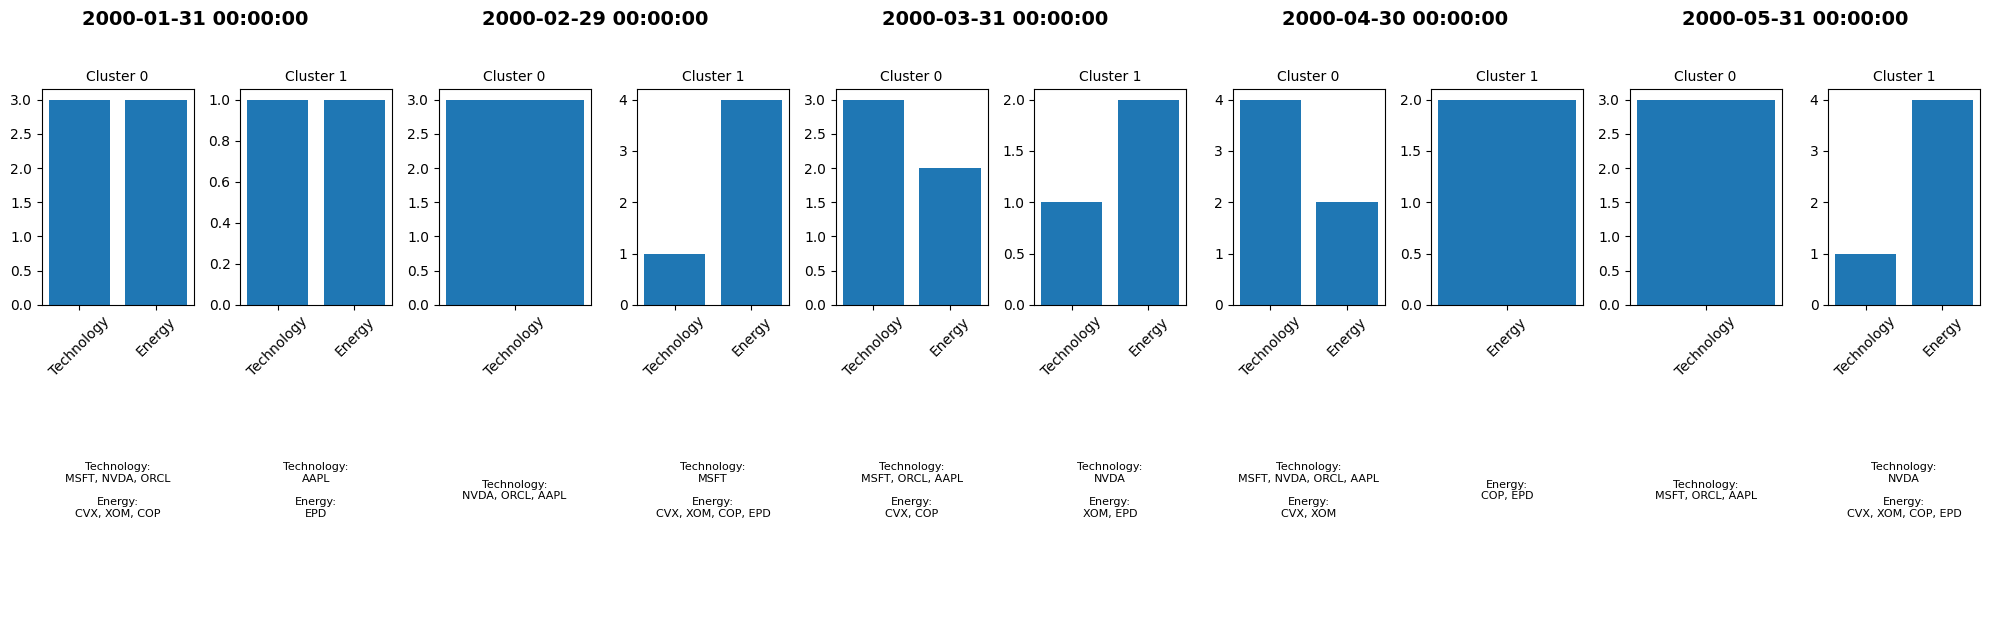

In [16]:
cluster_viz(results_df, Market_dict)